<a href="https://colab.research.google.com/github/timothy-voiuhy/CrackDetection/blob/main/crack_yolo_Segmentationv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.7/877.7 kB 16.2 MB/s eta 0:00:00


In [2]:
import os
import shutil
import glob
import json
import yaml
import cv2

import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# setup dataset directory
try:
    from google.colab import drive
    drive.mount("/content/drive")
    yolo_project_dir= "/content/drive/MyDrive/Models/Yolo_Cracks_SegmentationV1"
    local_dataset_dir = "/content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/"
    lastModel = "/content/drive/MyDrive/Models/Yolo_Cracks_Segmentation/train/weights/last.pt"
    bestModelPath = "/content/drive/MyDrive/Models/Yolo_Cracks_Segmentation/train/weights/best.pt"
except Exception as e:
    local_dataset_dir = "/home/kali/AI_ML/DATA/CCSS-DATA-V4-withVal/benchmarkingDatasets/"
    bestModelPath = "./CSModel.pt"
YOLO_YAML_FILE = local_dataset_dir+"yolo_dataset/data.yaml"

Mounted at /content/drive


In [ ]:
local_dataset_dir

'/content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/'

In [ ]:
# !kaggle datasets download -d parniashokri/ccssdata
# !unzip ccssdata.zip
# !mkdir BACKUP
# !cp -r CCSS-DATA-V4-withVal BACKUP
# !mkdir /content/datasets/
# ! rm -rf CCSS-DATA-V4-withVal
# ! cp -r BACKUP/CCSS-DATA-V4-withVal /content/datasets/
# !ls ./CCSS-DATA-V4-withVal/benchmarkingDatasets/
# !mv ./CCSS-DATA-V4-withVal /content/datasets/
!ls /content/datasets/

CCSS-DATA-V4-withVal


In [ ]:
input_dir_path= local_dataset_dir+"input/"
non_dir = local_dataset_dir+"train/noAugmentation-noPatch"
train_dir = local_dataset_dir+"train/traditionalAugmentation-withPatch/"
# train_images_dir = input_dir_path+"train"

In [ ]:
def organizeDir():
    if os.path.isdir(non_dir):
        shutil.rmtree(non_dir)
        for dir_name in os.listdir(train_dir):
            dir_path = os.path.join(train_dir, dir_name)
            shutil.move(dir_path, os.path.join(local_dataset_dir, 'train'))
        os.rmdir(train_dir)

    if not os.path.isdir(input_dir_path):
        os.mkdir(input_dir_path)

    for dir_name in os.listdir(local_dataset_dir):
        dir_path = os.path.join(local_dataset_dir, dir_name)
        if dir_name != "input":
            img_dir = os.path.join(dir_path, "img")
            mask_dir = os.path.join(dir_path, "lbl")
            new_img_dir = os.path.join(dir_path, f"{dir_name}Images")
            new_mask_dir = os.path.join(dir_path, f"{dir_name}Masks")
            if not os.path.isdir(new_mask_dir):
                os.rename(img_dir, new_img_dir)
                os.rename(mask_dir, new_mask_dir)
                shutil.move(new_img_dir, input_dir_path)
                shutil.move(new_mask_dir, input_dir_path)
                os.rmdir(dir_path)

    train_mask_dir = os.path.join(input_dir_path, "trainMasks")
    validation_mask_dir = os.path.join(input_dir_path, "validationMasks")
    test_mask_dir= os.path.join(input_dir_path, "testMasks")

    train_cracks_category_dir = os.path.join(train_mask_dir, "crack")
    val_cracks_category_dir = os.path.join(validation_mask_dir, "crack")
    test_cracks_category_dir = os.path.join(test_mask_dir, "crack")

    if not os.path.isdir(train_cracks_category_dir):
        if not os.path.isdir(train_cracks_category_dir):
            os.mkdir(train_cracks_category_dir)
            os.mkdir(val_cracks_category_dir)
            os.mkdir(test_cracks_category_dir)

        # Move files using shutil and glob instead of os.system
        for file_path in glob.glob(os.path.join(train_mask_dir, "*.jpg")):
            shutil.move(file_path, train_cracks_category_dir)

        for file_path in glob.glob(os.path.join(validation_mask_dir, "*.jpg")):
            shutil.move(file_path, val_cracks_category_dir)

        for file_path in glob.glob(os.path.join(test_mask_dir, "*.jpg")):
            shutil.move(file_path, test_cracks_category_dir)
# Call organizeDir to execute the function
organizeDir()

In [ ]:
# generating the yolodataset format
# first we convert our dataset into a coco format

# needed: json file file in each of the train test and validation images directories

# json dict format
COCO_FORMAT = {
    "info": {},
    "licenses": [],
    "images": [],
    "categories": [],
    "annotations": []
}

PLACEHOLDER = 0

# each image in the images list above is of the format:
IMAGE_FORMAT= {
    "id":PLACEHOLDER,
    "width":PLACEHOLDER,
    "height": PLACEHOLDER,
    "filename": PLACEHOLDER
}

#each annotation in the annotation is of the format

ANNOTATION_FORMAT = {
    "iscrowd":PLACEHOLDER,
    "id":PLACEHOLDER,
    "image_id": PLACEHOLDER,
    "category_id": PLACEHOLDER,
    "bbox": PLACEHOLDER,
    "area": PLACEHOLDER,
    "segmentation": [PLACEHOLDER, PLACEHOLDER, ...]
}

In [ ]:
cracks_paths = glob.glob(os.path.join(local_dataset_dir+"input/trainImages/", "*.jpg"))

In [ ]:
category_ids = {
    "Crack":1,
}
annotations = []
images = []

def getImagesAnnotations(masks_path):
    image_id = 0
    annotation_id = 0

    annotations = []
    images = []

    cracks_dir = os.path.join(masks_path, "crack")
    mask_paths = glob.glob(os.path.join(cracks_dir, "*.jpg"))

    for mask_image in mask_paths:
        original_file_name = f'{os.path.basename(mask_image).split(".")[0]}.jpg'
        mask_image_open = cv2.imread(mask_image)

        # Get image dimensions
        height, width, _ = mask_image_open.shape

        # Create or find existing image annotation
        if original_file_name not in map(lambda img: img['file_name'], images):
            image = {
                "id": image_id + 1,
                "width": width,
                "height": height,
                "file_name": original_file_name,
            }
            images.append(image)
            image_id += 1
        else:
            image = [element for element in images if element['file_name'] == original_file_name][0]

        # Find contours in the mask image
        gray = cv2.cvtColor(mask_image_open, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

        # Create annotation for each contour
        for contour in contours:
            bbox = cv2.boundingRect(contour)
            area = cv2.contourArea(contour)
            segmentation = contour.flatten().tolist()

            annotation = {
                "iscrowd": 0,
                "id": annotation_id,
                "image_id": image['id'],
                "category_id": 1,
                "bbox": bbox,
                "area": area,
                "segmentation": [segmentation],
            }
            # Add annotation if area is greater than zero
            if area > 0:
                annotations.append(annotation)
                annotation_id += 1
    return images, annotations, annotation_id

def process_masks(mask_path, dest_json):
    global image_id, annotation_id
    image_id = 0
    annotation_id = 0

    # Initialize the COCO JSON format with categories
    coco_format = {
        "info": {},
        "licenses": [],
        "images": [],
        "categories": [{"id": value, "name": key, "supercategory": key} for key, value in category_ids.items()],
        "annotations": [],
    }

    # Create images and annotations sections
    coco_format["images"], coco_format["annotations"], annotation_cnt = getImagesAnnotations(mask_path)

    # Save the COCO JSON to a file
    with open(dest_json, "w") as outfile:
        json.dump(coco_format, outfile, sort_keys=True, indent=4)

    print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_path))

In [ ]:
train_mask_path = os.path.join(local_dataset_dir+"input", "trainMasks")
train_json_path = local_dataset_dir+"input/trainImages/train.json"
process_masks(train_mask_path, train_json_path)

val_mask_path = os.path.join(local_dataset_dir+"input", "validationMasks")
val_json_path = local_dataset_dir+"input/validationImages/val.json"
process_masks(val_mask_path, val_json_path)

test_mask_path = os.path.join(local_dataset_dir+"input", "testMasks")
test_json_path = local_dataset_dir+"input/testImages/test.json"
process_masks(test_mask_path, test_json_path)

Created 28564 annotations for images in folder: /content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/input/trainMasks
Created 2065 annotations for images in folder: /content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/input/validationMasks
Created 2500 annotations for images in folder: /content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/input/testMasks


# The ultralytics yolo dataset format:
The dataset label format used for traiing YOLO segmentation models is as follows
1. Onet text file per image. Each image in the dataset has a corresponding text file with the same name as the image ile and the ".txt" file extension.
2. One row per object: Each row in the text file  corresponds to one object instance in the image.
3. Object information per row: Each row contains the following information about the object instance:
    Object class index: An interger representing the class of the object(eg 0 for       person , 1 for car etc).
    Object bounding coordinates: The bounding coordinates around the mask area, normalized to be between 0 and 1.

The format for a single row in the segmentation dataset file is as follows:
<\class-index> <\x1> <\y1> <\x2> <\y2> ... <\xn> <\yn>

In [ ]:
# now we change the coco format to yolo format
# Function to convert images to YOLO format
def convert_to_yolo(input_images_path, input_json_path, output_images_path, output_labels_path):
    # Open JSON file containing image annotations
    f = open(input_json_path)
    data = json.load(f)
    f.close()

    # Create directories for output images and labels
    os.makedirs(output_images_path, exist_ok=True)
    os.makedirs(output_labels_path, exist_ok=True)

    # List to store filenames
    file_names = []
    for filename in os.listdir(input_images_path):
        if filename.endswith(".jpg"):
            source = os.path.join(input_images_path, filename)
            destination = os.path.join(output_images_path, filename)
            shutil.copy(source, destination)
            file_names.append(filename)

    # Function to get image annotations
    def get_img_ann(image_id):
        return [ann for ann in data['annotations'] if ann['image_id'] == image_id]

    # Function to get image data
    def get_img(filename):
        return next((img for img in data['images'] if img['file_name'] == filename), None)

    # Iterate through filenames and process each image
    for filename in file_names:
        img = get_img(filename)
        img_id = img['id']
        img_w = img['width']
        img_h = img['height']
        img_ann = get_img_ann(img_id)

        # Write normalized polygon data to a text file
        if img_ann:
            with open(os.path.join(output_labels_path, f"{os.path.splitext(filename)[0]}.txt"), "a") as file_object:
                for ann in img_ann:
                    current_category = ann['category_id'] - 1
                    polygon = ann['segmentation'][0]
                    normalized_polygon = [format(coord / img_w if i % 2 == 0 else coord / img_h, '.6f') for i, coord in enumerate(polygon)]
                    file_object.write(f"{current_category} " + " ".join(normalized_polygon) + "\n")

# Function to create a YAML file for the dataset
def create_yaml(input_json_path, output_yaml_path, train_path, val_path, test_path=None):
    with open(input_json_path) as f:
        data = json.load(f)
    # Extract the category names
    names = [category['name'] for category in data['categories']]
    # Number of classes
    nc = len(names)
    # Create a dictionary with the required content
    yaml_data = {
        'names': names,
        'nc': nc,
        'test': test_path if test_path else '',
        'train': train_path,
        'val': val_path
    }
    # Write the dictionary to a YAML file
    with open(output_yaml_path, 'w') as file:
        yaml.dump(yaml_data, file, default_flow_style=False)


In [ ]:
base_input_path = local_dataset_dir+"input/"
base_output_path = local_dataset_dir+"yolo_dataset/"

# Processing validation dataset (if needed)
convert_to_yolo(
    input_images_path=os.path.join(base_input_path, "validationImages"),
    input_json_path=os.path.join(base_input_path, "validationImages/val.json"),
    output_images_path=os.path.join(base_output_path, "valid/images"),
    output_labels_path=os.path.join(base_output_path, "valid/labels")
)

# Processing training dataset
convert_to_yolo(
    input_images_path=os.path.join(base_input_path, "trainImages"),
    input_json_path=os.path.join(base_input_path, "trainImages/train.json"),
    output_images_path=os.path.join(base_output_path, "train/images"),
    output_labels_path=os.path.join(base_output_path, "train/labels")
)

convert_to_yolo(
    input_images_path=os.path.join(base_input_path, "testImages"),
    input_json_path=os.path.join(base_input_path, "testImages/test.json"),
    output_images_path=os.path.join(base_output_path, "test/images"),
    output_labels_path=os.path.join(base_output_path, "test/labels")
)

In [ ]:
    # Creating the YAML configuration file
create_yaml(
    input_json_path=os.path.join(base_input_path, "trainImages/train.json"),
    output_yaml_path=os.path.join(base_output_path, "data.yaml"),
    train_path=local_dataset_dir+"yolo_dataset/train/images",
    val_path=local_dataset_dir+"yolo_dataset/valid/images",
    test_path=local_dataset_dir+"yolo_dataset/test/images"
)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU found")
else:
    print("GPU not found. Using CPU")
    device = torch.device("cpu")

GPU found


In [ ]:
# training the yolo model on the data
model = YOLO("yolo11n-seg.pt")


100%|██████████| 5.90M/5.90M [00:00<00:00, 128MB/s]


In [ ]:
results = model.train(
    data = YOLO_YAML_FILE,
    epochs = 30,
    project = yolo_project_dir,
    batch = 32,
    verbose= True,
    save = True,
    device = device,
    patience = 5
)

engine/trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=/content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/yolo_dataset/data.yaml, epochs=30, time=None, patience=5, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=/content/drive/MyDrive/Models/Yolo_Cracks_SegmentationV1, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

100%|██████████| 755k/755k [00:00<00:00, 23.4MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 89.3MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/yolo_dataset/train/labels... 2648 images, 134 backgrounds, 0 corrupt: 100%|██████████| 2782/2782 [00:02<00:00, 1002.50it/s]


train: New cache created: /content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/yolo_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/yolo_dataset/valid/labels... 176 images, 5 backgrounds, 0 corrupt: 100%|██████████| 181/181 [00:00<00:00, 309.74it/s]


val: New cache created: /content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/yolo_dataset/valid/labels.cache
Plotting labels to /content/drive/MyDrive/Models/Yolo_Cracks_SegmentationV1/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Models/Yolo_Cracks_SegmentationV1/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/30      7.09G      1.908      2.667      2.677      1.601        339        640: 100%|██████████| 87/87 [02:05<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.23s/it]

                   all        181       2065      0.133     0.0436     0.0157    0.00625     0.0344     0.0116    0.00342   0.000906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/30      6.13G      2.006      2.195      2.354      1.611        280        640: 100%|██████████| 87/87 [01:58<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.12s/it]

                   all        181       2065      0.116     0.0877      0.037     0.0144     0.0555     0.0518     0.0111    0.00261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.65G      1.964      2.118      2.242      1.589        309        640: 100%|██████████| 87/87 [01:55<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

                   all        181       2065      0.059     0.0547     0.0127    0.00445     0.0343     0.0286    0.00612     0.0016



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/30      7.57G      1.987      2.185      2.246      1.608        255        640: 100%|██████████| 87/87 [01:56<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

                   all        181       2065      0.138      0.105     0.0468     0.0184     0.0751       0.06     0.0204    0.00538



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/30       7.1G      1.883      2.055      2.118      1.556        298        640: 100%|██████████| 87/87 [02:00<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.35s/it]

                   all        181       2065      0.161     0.0906     0.0472     0.0207      0.121     0.0625     0.0274    0.00568



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.09G      1.842      2.064      2.062      1.521        348        640: 100%|██████████| 87/87 [02:15<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.09s/it]

                   all        181       2065      0.199     0.0983      0.064     0.0263      0.138     0.0659      0.037    0.00955



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/30      7.14G      1.816      2.009      2.033      1.508        249        640: 100%|██████████| 87/87 [01:55<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.11s/it]

                   all        181       2065      0.209      0.112     0.0664     0.0288      0.221     0.0915     0.0547     0.0157



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/30      7.59G       1.76      1.995      1.969       1.48        411        640: 100%|██████████| 87/87 [01:55<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

                   all        181       2065      0.209      0.113     0.0771     0.0327      0.205     0.0891     0.0603     0.0163



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/30       7.3G      1.734      1.985      1.955      1.458        339        640: 100%|██████████| 87/87 [01:57<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

                   all        181       2065      0.205      0.112     0.0802     0.0351      0.199     0.0877     0.0559     0.0151



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/30      7.64G      1.712      1.928      1.901      1.442        380        640: 100%|██████████| 87/87 [01:55<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.31s/it]

                   all        181       2065      0.229      0.115     0.0842     0.0388      0.204     0.0886     0.0582     0.0156



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/30      7.59G      1.653      1.907      1.848      1.425        357        640: 100%|██████████| 87/87 [01:54<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.96s/it]

                   all        181       2065       0.23       0.13      0.093      0.043      0.209      0.108     0.0742     0.0226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.91G      1.664      1.928      1.852      1.421        316        640: 100%|██████████| 87/87 [01:52<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]

                   all        181       2065      0.244      0.124     0.0931     0.0429      0.242      0.104     0.0726     0.0219



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.65G      1.659      1.901      1.849      1.416        320        640: 100%|██████████| 87/87 [01:57<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

                   all        181       2065      0.268      0.142      0.106     0.0484      0.228      0.106     0.0772     0.0211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/30      8.52G       1.64      1.898      1.814      1.403        347        640: 100%|██████████| 87/87 [01:59<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

                   all        181       2065      0.268      0.138      0.102     0.0486      0.242      0.102     0.0755     0.0212



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.91G      1.616      1.884      1.798      1.398        355        640: 100%|██████████| 87/87 [01:57<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


                   all        181       2065      0.273      0.139      0.107     0.0508      0.257      0.111      0.084     0.0242

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/30      7.14G       1.58      1.835      1.765       1.38        276        640: 100%|██████████| 87/87 [01:55<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.31s/it]

                   all        181       2065      0.288      0.148      0.113     0.0509      0.245      0.115     0.0852     0.0247



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/30      7.79G       1.57      1.831      1.741      1.376        340        640: 100%|██████████| 87/87 [01:55<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.15s/it]

                   all        181       2065      0.293      0.144      0.108     0.0487       0.26      0.117     0.0927      0.025



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/30      6.96G      1.552      1.801      1.735      1.363        452        640: 100%|██████████| 87/87 [01:55<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

                   all        181       2065      0.297      0.144      0.111     0.0525      0.275      0.113     0.0892     0.0266



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/30      7.17G      1.527      1.806        1.7      1.349        318        640: 100%|██████████| 87/87 [01:59<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

                   all        181       2065      0.295      0.151      0.125     0.0621      0.276      0.112     0.0918     0.0252



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/30      7.09G      1.524      1.802      1.695      1.341        248        640: 100%|██████████| 87/87 [01:54<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.43s/it]

                   all        181       2065      0.313      0.143      0.122     0.0587      0.363      0.104     0.0943     0.0246


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.88G      1.764      1.876          2      1.528        248        640: 100%|██████████| 87/87 [01:19<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        181       2065      0.293      0.144      0.111     0.0562      0.294      0.108       0.08     0.0252



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/30      7.12G       1.73      1.838      1.954      1.504        185        640: 100%|██████████| 87/87 [01:13<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]

                   all        181       2065      0.331      0.148      0.131      0.065      0.287      0.123      0.102     0.0296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/30      7.24G      1.717      1.851      1.929      1.507        215        640: 100%|██████████| 87/87 [01:13<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

                   all        181       2065      0.284      0.154      0.124     0.0614      0.308      0.121      0.102     0.0313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.93G      1.694      1.814      1.908      1.486        293        640: 100%|██████████| 87/87 [01:13<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        181       2065      0.327      0.152      0.135      0.068      0.291      0.109     0.0987     0.0292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.61G      1.669      1.809      1.876      1.473        159        640: 100%|██████████| 87/87 [01:14<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

                   all        181       2065      0.311      0.156      0.131     0.0696      0.281      0.119      0.105     0.0346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/30      7.49G       1.66      1.789       1.85      1.466        194        640: 100%|██████████| 87/87 [01:11<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]

                   all        181       2065      0.333      0.151      0.132     0.0693      0.302      0.121      0.104     0.0331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.88G      1.626      1.787      1.829       1.45        210        640: 100%|██████████| 87/87 [01:13<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        181       2065       0.33      0.157      0.137       0.07      0.279      0.122      0.105     0.0322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/30      7.98G      1.605      1.764      1.805      1.436        186        640: 100%|██████████| 87/87 [01:13<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all        181       2065      0.337      0.163      0.143     0.0753      0.292      0.119      0.107     0.0337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/30       6.9G      1.577      1.742      1.777       1.42        251        640: 100%|██████████| 87/87 [01:13<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

                   all        181       2065      0.334      0.162      0.144     0.0766      0.305      0.122      0.111     0.0343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/30         8G      1.567      1.739      1.752      1.397        177        640: 100%|██████████| 87/87 [01:12<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.36s/it]

                   all        181       2065      0.346      0.165      0.149     0.0786       0.31      0.134      0.121     0.0379



30 epochs completed in 0.917 hours.
Optimizer stripped from /content/drive/MyDrive/Models/Yolo_Cracks_SegmentationV1/train/weights/last.pt, 6.0MB
Optimizer stripped from /content/drive/MyDrive/Models/Yolo_Cracks_SegmentationV1/train/weights/best.pt, 6.0MB

Validating /content/drive/MyDrive/Models/Yolo_Cracks_SegmentationV1/train/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n-seg summary (fused): 265 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


                   all        181       2065      0.343      0.164      0.148     0.0785      0.308      0.137      0.122      0.038
Speed: 0.2ms preprocess, 3.6ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to /content/drive/MyDrive/Models/Yolo_Cracks_SegmentationV1/train


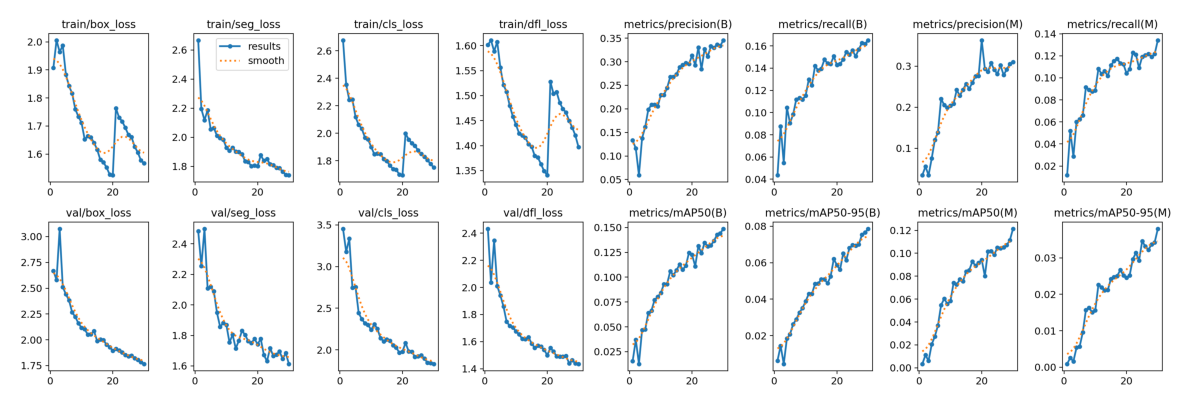

In [ ]:
# the Results graphs images
image_path = os.path.join(yolo_project_dir, "train/results.png")
image = Image.open(image_path)
# image.show()
plt.figure(figsize=(15, 30))
plt.imshow(image)
plt.axis('off')
plt.show()

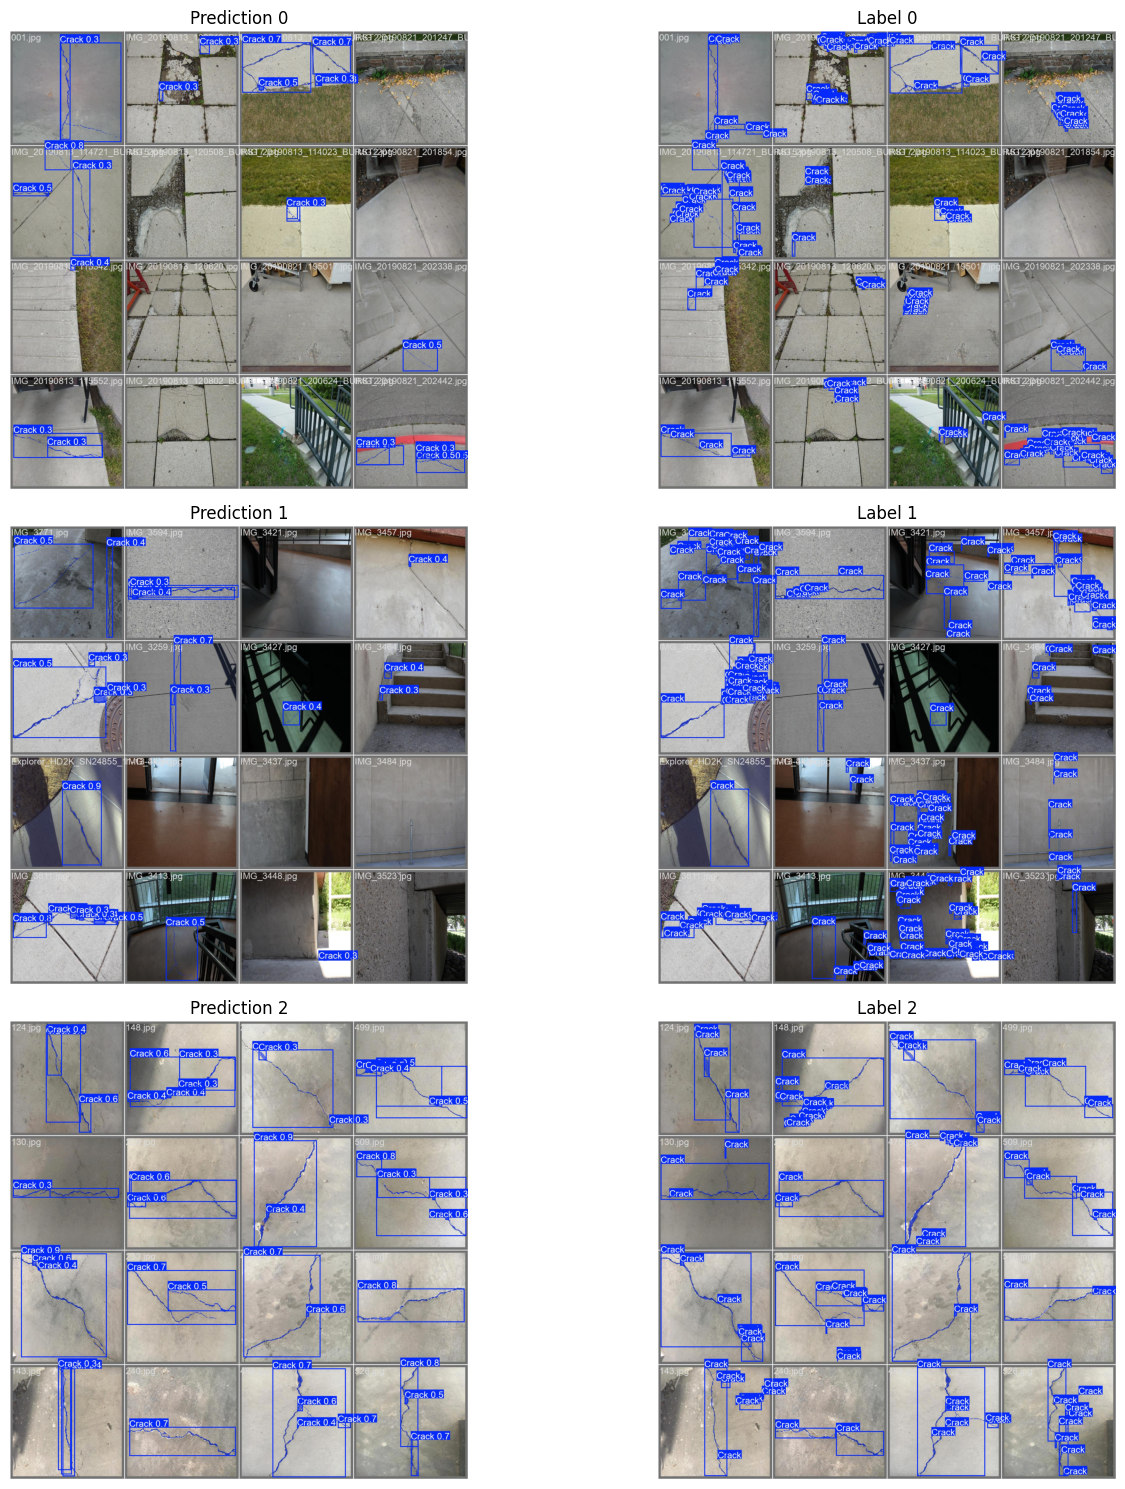

In [10]:
# validation batch images
plt.figure(figsize=(15, 15))
idx = 1

for i in range(3):
    pred_image_path = os.path.join(yolo_project_dir, f"train/val_batch{i}_pred.jpg")
    label_image_path = os.path.join(yolo_project_dir, f"train/val_batch{i}_labels.jpg")

    if os.path.exists(pred_image_path):
        pred_image = Image.open(pred_image_path)
    else:
        print(f"Prediction image not found: {pred_image_path}")
        continue

    plt.subplot(3, 2, idx)
    plt.imshow(pred_image)
    plt.title(f"Prediction {i}")
    plt.axis('off')

    if os.path.exists(label_image_path):
        label_image = Image.open(label_image_path)
    else:
        print(f"Label image not found: {label_image_path}")
        continue

    plt.subplot(3, 2, idx + 1)
    plt.imshow(label_image)
    plt.title(f"Label {i}")
    plt.axis('off')

    idx += 2  # Increment by 2 for the next pair of images

plt.tight_layout()
plt.show()
# image

In [ ]:
stats_dir = "./cracksSegmentation/train2"

def visualize_images(directory):
    # Filter out non-image files by checking file extensions
    image_files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Define the grid size for visualization (e.g., 3x3, or adjust as needed)
    num_images = len(image_files)
    cols = 3
    rows = (num_images // cols) + (num_images % cols > 0)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.ravel()  # Flatten the axes array for easy iteration

    # Loop through each image file and display it
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(directory, image_file)
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].set_title(image_file)
        axes[i].axis('off')

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_images(stats_dir)